# Homework: Machine Learning

This notebook is a graded homework that you will turn in.

You *may*:
* Ask questions of and work with other students in this course. You must each write up your own solutions.
* Ask questions of the instructor. Your instructor is generous with hints and guidance.
* Use the [Python Documentation](https://docs.python.org/3.11/), especially the [tutorial section](https://docs.python.org/3/tutorial/index.html).
* Use the PyTorch and fast.ai documentation.
* Use the [W3Schools](https://www.w3schools.com/python/) and [Python For Everbody](https://www.py4e.com/) tutorials/reference guides.

You *may not*:
* Discuss this with any other students, faculty, your friends, your family, &c. before it is submitted.
* Use Stack Overflow, Google, ChatGPT or other unspecified resources.


## Problems in this Notebook

1. Learning Rate Finder
2. Overfitting
3. Overfitting + L2 Regularization


In [2]:
from fastai.basics import *
import torch
import pandas as pd
import numpy as np

# 0 Dataset

For this notebook, we'll be using the following dataset, which I randomly generated. We'll use a general high-degree polynomial as the function to fit:

$P_9(x) = w_0 + w_1 x + w_2 x^2 + w_3 x^3 + \cdots + w_9 x^9$

Define the function below. `w` is a tensor with length 10 (with entries `w[0]` through `w[9]`).

In [3]:
def P9(x, w):
    # Complete the function
    return w[0] + w[1]*x + w[2]*x.pow(2) + w[3]*x.pow(3) + w[4]*x.pow(4) + w[5]*x.pow(5) + w[6]*x.pow(6) + w[7]*x.pow(7) + w[8]*x.pow(8) + w[9]*x.pow(9)

,x,y
0,-0.5,-41.411019
1,0.3,-4.893795
2,0.2,-23.429233
3,0.7,15.147770
4,-0.1,-1.528786


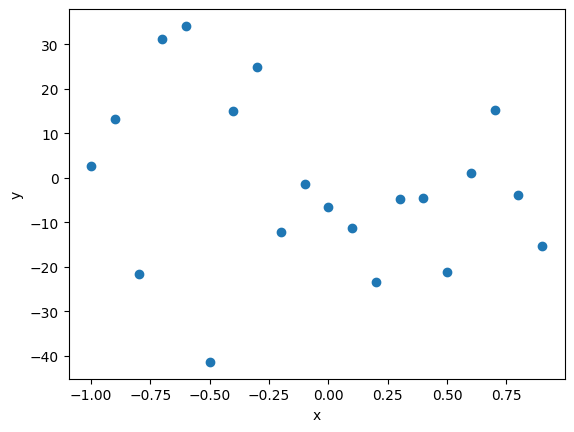

In [4]:
data = pd.read_csv("https://raw.githubusercontent.com/Greg-Hallenbeck/class-datasets/main/datasets/hw2.csv")
x,y = data["x"],data["y"]

plt.scatter(x, y); plt.xlabel("x"); plt.ylabel("y")
data.head()

# 1. Learning Rate Finder

**Please Note: Do *not* use mini-batch descent for any of these problems. Just use all of the data each time.**

So far, we've been just using the same learning rate of $\lambda = 0.01$ for every problem, and sometimes modifying it when it's not the right one. But there's no reason that it should *always* be 0.01. The dataset we're working with is particularly tricky to fit well, because $x^9$ grows very rapidly, so your initial loss will be very large. It might be a good idea to, before starting gradient descent, figure out what learning rate would be best. This is a *learning rate finder*.

The algorithm for this is pretty simple:
1. Initialize your parameters
2. Train the model for one epoch with a variety of different values of $\lambda$, and record what the loss will be after that epoch of training. Use the same initial parameters for each of these.
3. Make a plot of those losses. The $\lambda$ corresponding to the minimum loss (or a $\lambda$ just below that) will be the best value to train at.

Some hints:
* *Don't* actually change the parameters during this process. Figure out what the loss *would be* with the new parameters, then reset to the original values after each step.
* You don't need to loop over minibatches. The dataset is tiny, so you can do this all with just a single batch.
* There's not much different between a learning rate of 0.03 and 0.04. We need to vary $\lambda$ by a huge amount. For this problem, our learning rate needs to be somewhere between from say $10^{-3}$ and $10^{0.3}$. To accomplish this, generate the lambdas in the following way:
`lrs = 10**np.arange(-3,0.3,0.02)`.
* Similarly, when you make the loss plot, make the x scale logarithmic using `plt.xscale("log")`.

1. Make a learning rate finder for the dataset and function defined above.
2. Make a plot of learning rate on the x axis, and loss after 1 epoch on the y. Mine looks like [this image](https://github.com/Greg-Hallenbeck/class-datasets/blob/main/images/lr_find.png?raw=true), but results may vary slightly based on starting parameters.
3. State explicitly: what is the best learning rate for this problem?

In [5]:
x = torch.tensor(data["x"])
y = torch.tensor(data["y"])

In [6]:
def loss(y, yhat):
  return (y-yhat).pow(2).mean()

In [7]:
w = torch.rand(10)
w.requires_grad_()

tensor([0.1359, 0.8004, 0.8632, 0.8522, 0.3374, 0.9663, 0.9319, 0.4032, 0.4959,
        0.2778], requires_grad=True)

In [8]:
lrs = 10**np.arange(-3,0.3,0.02)

In [9]:
x

tensor([-5.0000e-01,  3.0000e-01,  2.0000e-01,  7.0000e-01, -1.0000e-01,
        -7.0000e-01,  1.0000e-01, -8.0000e-01, -4.0000e-01, -1.0000e+00,
        -2.0000e-01,  6.0000e-01, -6.0000e-01,  5.0000e-01,  4.0000e-01,
        -3.0000e-01, -9.0000e-01,  2.8422e-13,  8.0000e-01,  9.0000e-01],
       dtype=torch.float64)

In [10]:
losses = []

for lr in lrs:
  yhat = P9(x, w)
  J = loss(y, yhat)

  J.backward()

  with torch.no_grad():
   # the "learning" is right here
   # w = w - lr * w.grad
    wnew = w - lr * w.grad

  yhat = P9(x, wnew)
  J = loss(y, yhat)
  losses.append(float(J))

  w.grad.data.zero_()

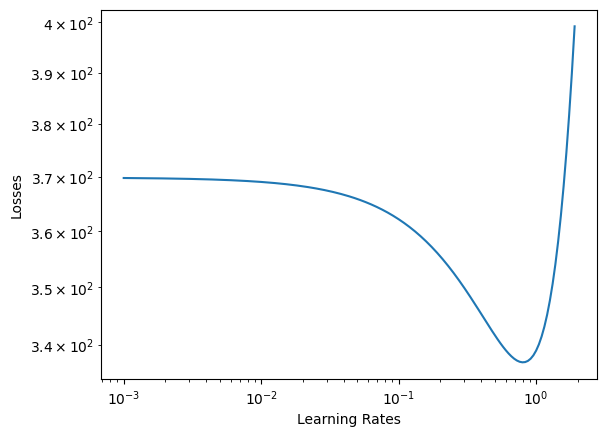

In [11]:
plt.plot(lrs, losses)
plt.xlabel("Learning Rates")
plt.ylabel("Losses")
plt.xscale("log")
plt.yscale("log")

In [12]:
losses[torch.argmin(tensor(losses))]

# The best learning rate for this problem would be approximately 0.7.

337.01140195001307

# 2. Overfitting

1. Split the dataset in two: a *training set* with the first 15 data points and a *validation set* with the remaining 5.

2. Fit the dataset using just the training set for 100 epochs. At the end of each epoch, evaluate the loss not only on the training set but also on the validation set. This means you'll be tracking the loss in two variables.

3. Make a plot of the loss for the training and validation sets, on a single set of axes.

4. To assess overfitting, look for when the model continues to improve on the training set, but gets worse on the validation set. Is there overfitting? At approximately what epoch did overfitting begin?



In [13]:
training = data.iloc[:15].reset_index()
validation = data.iloc[15:].reset_index()

In [14]:
train_x = torch.tensor(training["x"])
train_y = torch.tensor(training["y"])

In [15]:
validate_x = torch.tensor(validation["x"])
validate_y = torch.tensor(validation["y"])

In [16]:
w = torch.rand(10)
w.requires_grad_()
train_losses = []
validate_losses = []

In [17]:
for epoch in range(100):

    yhat = P9(train_x, w)
    J_train = loss(train_y, yhat)
    train_losses.append(float(J_train))

    J_train.backward()

    lr = 0.1

    with torch.no_grad():
        w.sub_(lr * w.grad)

    yhat = P9(validate_x, w)
    J_validate = loss(validate_y, yhat)
    validate_losses.append(float(J_validate))

    w.grad.data.zero_()

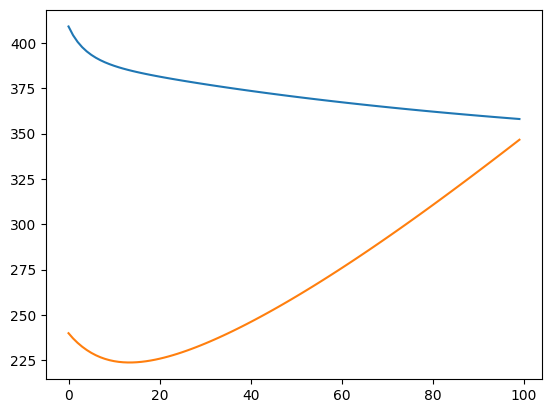

In [18]:
plt.plot(train_losses)
plt.plot(validate_losses)

# There is overfitting. At approximately 15 epoch, the overfitting occurs.

In [19]:
w

tensor([-6.7748, -6.2922, 13.9148,  4.2429,  5.0673,  5.3996,  0.8776,  4.3308,
        -0.2575,  3.5757], requires_grad=True)

# 3. Regularization

One way to prevent overfitting is called *regularization*, which modifies the loss function to explicitly take into account how many and how strong each parameter is. One example is the L2 regularization method, adding every parameter squared multiplied by some hyperparameter $\lambda_2$:

$$J_{L2} = \frac{1}{N}\sum_i (\hat{y}_i - y)^2 + \lambda_2 \sum_j w_j^2$$

(In this case, the $w_j$ represent *all* model parameters, even if some are called $b$ or whatever)

*Hint: this problem is very straightforward if you start by copying and paste your code from Problem 2.*

1. Implement L2 regularization on the problem you've been working on, with a choice of $\lambda_2 = 0.1$
2. Plot the training and validation losses after fitting for 100 epochs.
3. Describe: how has the L2 regularization affected the overfitting? Is there less overfitting? More? The same amount?
4. Compare: Qualitatively, is each of the $w$ values you got here larger or smaller than from Problem 2? Why?

In [20]:
def newloss(y, yhat, l2, w):
  return (y-yhat).pow(2).mean() + l2 * sum((w).pow(2))

In [29]:
w = torch.rand(10)
w.requires_grad_()
l2 = 0.1
train_losses = []
validate_losses = []

In [30]:
for epoch in range(100):

    yhat = P9(train_x, w)
    J_train = newloss(train_y, yhat, l2, w)
    train_losses.append(float(J_train))

    J_train.backward()

    lr = 0.1

    with torch.no_grad():
        w.sub_(l2 * w.grad)

    yhat = P9(validate_x, w)
    J_validate = newloss(validate_y, yhat, l2, w)
    validate_losses.append(float(J_validate))

    w.grad.data.zero_()

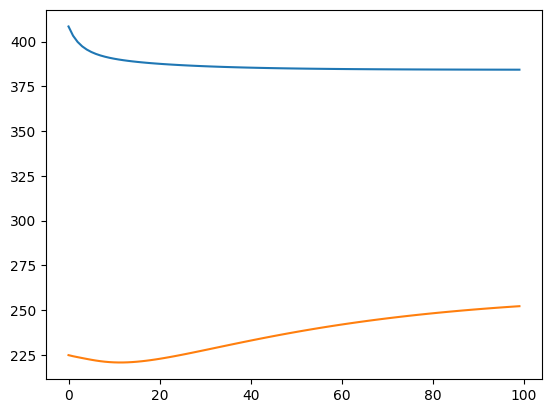

In [31]:
plt.plot(train_losses)
plt.plot(validate_losses)

# The L2 regulation did seem to affect the overfitting. There appears to be less
# overfitting with the L2 regulation. Compared to the w values in Problem 2, any
# of the negative values in this problem are greater than the ones in Problem 2,
# and any of the positive values are smaller than the ones in Problem 2.

In [32]:
w

tensor([-4.5056, -3.8471,  6.2070,  1.4863,  2.6003,  1.9877,  0.5248,  1.6540,
        -0.1486,  1.2172], requires_grad=True)